<a href="https://colab.research.google.com/github/narendrapahuja/KBS-Project/blob/master/air_quality_dataset_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing ML in Air Quality Data for knowledge discovery

In this notebook, we have applied machine learning techniques to predict the temperature from the air quality. We have leveraged the [Historical Air Quality](https://console.cloud.google.com/marketplace/details/epa/historical-air-quality) database hosted as BigQuery's public data. The database contains 32 tables describing the existance of different particles in the air on daily and hourly basis all over the US. In our previous study (in Deliverables 3), we have analyzed they key factors and conditions of the air quality in various crowded cities in different states. Based on that analysis, we have identified the key particles (features) that might make an impact on the temperatures.

# Section 1: Forecasting AQI

Importing dependencies

In [0]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-whitegrid')

%matplotlib inline

Authenticating google colab to work with GCP

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# Loading data from Big Query

In this section, we'll be loading AQI data from big query to use for forcasting future AQI. AQI is the measurement that we'll be using to look at air quality. Big Query results are loaded into daily_summary_df dataframe which will be used in later sections.

In [0]:
%%bigquery --project kbs-project-273101 daily_summary_df
SELECT
  extract(DAYOFYEAR from date_local) as day_of_year,
  aqi as AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
  WHERE
    city_name = "Charlotte"
    AND state_name = "North Carolina"
    AND sample_duration = "24 HOUR"
    AND poc = 1
    AND EXTRACT(YEAR FROM date_local) = 2017
ORDER BY day_of_year

Here is a visualization of what we got from Big Query.

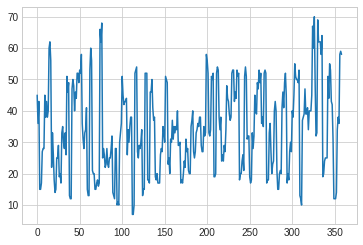

In [0]:
daily_summary_df['AQI'].plot()

# Training Model to predict AQI

In order for our big query data to work with the the model we're going to use, we need to convert dataframes to numpy arrays and split them into training/testing sets. Since AQI is what we are trying to forcast, it becomes our training/test set.

In [0]:
# Begin by shaping the data
aqi_f = np.array(daily_summary_df['AQI'])
# This size will be used to split data into its training and validation sets
training_size = int(len(aqi_f)*3/4)
# Seperate data into training/validation sets
train_set = aqi_f[0:training_size]
test_set = aqi_f[training_size:]

Here is the model we'll be using to predict AQI. It is an LSTM (Long short term memory) network, which is a derivative of RNN's (Recurrent Neural Networks).

To learn more about LSTM networks, I recommend the following: 
[Machine Learning Mastery: A Gentle Introduction to Long Short-Term Memory Networks by the Experts](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts)

In [0]:
# Inspired by https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Function is used to split a univariate sequence into samples. The formatting of these samples are 
# important for the lstm network to be able to lookback at the past AQI for predicting the next AQI
def split_sequence(sequence, n_steps):
  """split_sequence(sequence, n_steps)

  Function is used to split a univariate sequence into samples.

  sequence: 
    training or testing set we'll be seperating into univeriate squence
  n_steps:
    number of steps to look back at to predict
  """
  set_x, set_y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    set_x.append(seq_x)
    set_y.append(seq_y)
  return np.array(set_x), np.array(set_y)

# The number of steps we are looking back at to predict the next AQI variable
lookback_length = 4
# Split sequence
X, y = split_sequence(train_set, lookback_length)
# Reshape numpy arrays for model
X = X.reshape((X.shape[0], X.shape[1], 1))

Here we create and train our model. We'll be using Keras to create and train our LSTM network. It is basic with a single LSTM layer and Dense layer

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lookback_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=500, verbose=0)

Now let's test our trained model! We'll use the testing set derived from [9] to predict new AQI values, and then visualizing them alongside the actual AQI.

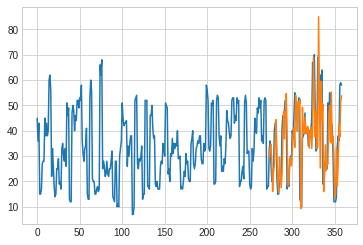

In [0]:
test_x, test_y = split_sequence(test_set, lookback_length)
predicted_results = []
# Format results for visualization
for idx in range(len(test_y)):
  result = model.predict(test_x[idx].reshape(1, lookback_length, 1))
  predicted_results.extend(result.tolist()[0])

for _ in range(training_size+lookback_length):
  predicted_results.insert(0,None) 

daily_summary_df['AQI'].plot()
plt.plot(predicted_results)

# Section 2: Forecasting Temperature

This query retrieves the daily summary of the air quality index from the database, in a pattern like we did in the data analysis phase. Instead of focusing on a city, we have arbitrarily selected a list of states. Considerably, these are one of the busiest cities in US.

In [0]:
%%bigquery --project kbs-project-273101 daily_summary_df
SELECT
  extract(DAYOFYEAR from date_local) as day_of_year,
  avg(aqi) as AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
  WHERE
    state_name IN ('Florida', 'California', 'New York', 'Texas')
    AND sample_duration = "24 HOUR"
    AND poc = 1
    AND EXTRACT(YEAR FROM date_local) = 2017
GROUP BY day_of_year
ORDER BY day_of_year

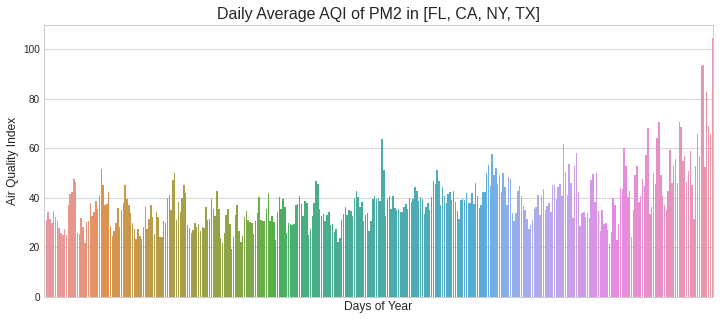

In [0]:
# daily_summary_df.plot(x='day_of_year', y='AQI', style='.');
plt.subplots(figsize=(12,5))
sns.barplot(data=daily_summary_df, x='day_of_year', y='AQI')
plt.ylabel('Air Quality Index', fontsize=12)
plt.xticks(ticks=[])
plt.xlabel('Days of Year', fontsize=12)
plt.title('Daily Average AQI of PM2 in [FL, CA, NY, TX]', fontsize=16)
plt.show()

We can see some spikes in AQI in the later parts of the year and a spike in the mid year on the chart above most likely during 4th of July. From our analysis we became interested to measure the impact of the existing particles of air in teperature change.

# Retrieving Data from BigQuery

We planned to consider each of the existing particles in the air as a feature in our model. These information are stored in detail in separate tables for each of the states. We retrieved the data for some arbitrarily selected states. We also retrieved the historical temperature from the data table to check the trend of the temperature over the year.

In [0]:
%%bigquery --project kbs-project-273101 df_temperature
SELECT
  extract(DAYOFYEAR FROM tds.date_local) AS day, avg(tds.arithmetic_mean) AS temperature
FROM
  `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary` as tds
WHERE
  tds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_humidity
SELECT
  extract(DAYOFYEAR FROM rhdds.date_local) AS day, AVG(rhdds.arithmetic_mean) AS humidity
FROM
  `bigquery-public-data.epa_historical_air_quality.rh_and_dp_daily_summary` as rhdds
WHERE
  rhdds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_ozone
SELECT
  extract(DAYOFYEAR FROM o3ds.date_local) AS day, AVG(o3ds.aqi) AS o3AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.o3_daily_summary` as o3ds
WHERE
  o3ds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_ntrdioxide
SELECT
  extract(DAYOFYEAR FROM no2ds.date_local) AS day, AVG(no2ds.aqi) AS no2AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` as no2ds
WHERE
  no2ds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_clrodorless
SELECT
  extract(DAYOFYEAR FROM cods.date_local) AS day, AVG(cods.aqi) AS coAQI
FROM
  `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as cods
WHERE
  cods.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_particulatematter
SELECT
  extract(DAYOFYEAR FROM pm25ds.date_local) AS day, AVG(pm25ds.aqi) AS pm25AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as pm25ds
WHERE
  pm25ds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
  AND pm25ds.sample_duration = '24 HOUR'
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_sulphurdioxide
SELECT
  extract(DAYOFYEAR FROM so2ds.date_local) AS day, AVG(so2ds.aqi) AS so2AQI
FROM
  `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as so2ds
WHERE
  so2ds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_wind
SELECT
  extract(DAYOFYEAR FROM wds.date_local) AS day, AVG(wds.arithmetic_mean) AS wind
FROM
  `bigquery-public-data.epa_historical_air_quality.wind_daily_summary` as wds
WHERE
  wds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

In [0]:
%%bigquery --project kbs-project-273101 df_pressure
SELECT
  extract(DAYOFYEAR FROM pds.date_local) AS day, AVG(pds.arithmetic_mean) AS pressure
FROM
  `bigquery-public-data.epa_historical_air_quality.pressure_daily_summary` as pds
WHERE
  pds.state_name IN ('Florida', 'California', 'Illinois', 'New York', 'Texas')
GROUP BY day
ORDER BY day

# Processing the Retrieved Data

We visualized the separately retrieved data frame from BigQuery in a compund plot. Below, we can identify the pattern each attribute shows and how they flacture as a year goes through.

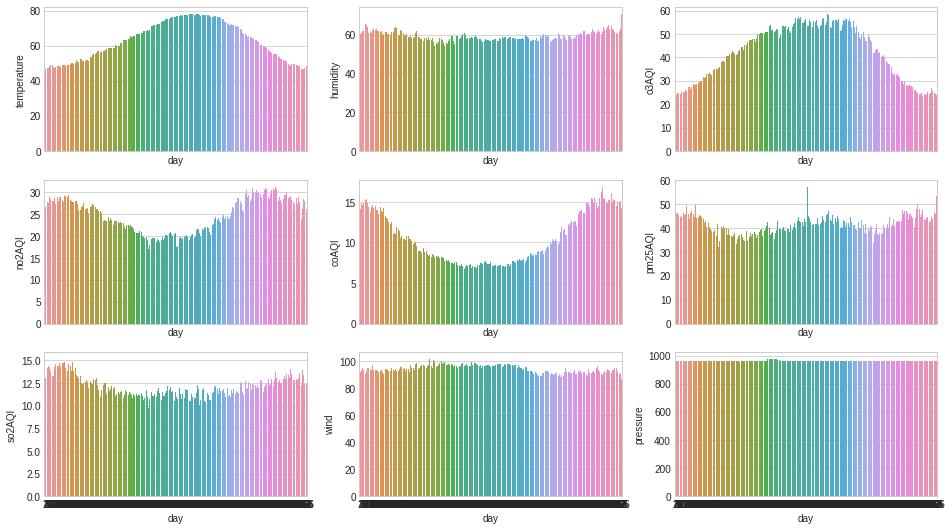

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 9), sharex=True)

sns.barplot(data=df_temperature, x='day', y='temperature', ax=ax[0, 0])
sns.barplot(data=df_humidity, x='day', y='humidity', ax=ax[0, 1])
sns.barplot(data=df_ozone, x='day', y='o3AQI', ax=ax[0, 2])

sns.barplot(data=df_ntrdioxide, x='day', y='no2AQI', ax=ax[1, 0])
sns.barplot(data=df_clrodorless, x='day', y='coAQI', ax=ax[1, 1])
sns.barplot(data=df_particulatematter, x='day', y='pm25AQI', ax=ax[1, 2])

sns.barplot(data=df_sulphurdioxide, x='day', y='so2AQI', ax=ax[2, 0])
sns.barplot(data=df_wind, x='day', y='wind', ax=ax[2, 1])
sns.barplot(data=df_pressure, x='day', y='pressure', ax=ax[2, 2])

# plt.setp(xticks=[])

Setting the data frame index to be able to join the dataframes later to a single dataframe. The resulted data frame has all 9 attributes that we retrieved from BigQuery. A cell below shows 10 random samples from the final dataframe that we prepared.

In [0]:
def set_index(df):
  if df.index.name != 'day':
    df = df.set_index('day')
  return df

df_temperature = set_index(df_temperature)
df_humidity = set_index(df_humidity)
df_ozone = set_index(df_ozone)
df_ntrdioxide = set_index(df_ntrdioxide)
df_clrodorless = set_index(df_clrodorless)
df_particulatematter = set_index(df_particulatematter)
df_sulphurdioxide = set_index(df_sulphurdioxide)
df_wind = set_index(df_wind)
df_pressure = set_index(df_pressure)

In [0]:
df_daily_summary = pd.concat([df_humidity, df_ozone, df_ntrdioxide, df_clrodorless, df_particulatematter, df_sulphurdioxide, df_wind, df_pressure, df_temperature], axis=1, join='inner')
df_daily_summary.sample(10, random_state = 15)

,humidity,o3AQI,no2AQI,coAQI,pm25AQI,so2AQI,wind,pressure,temperature
day,,,,,,,,,
84,58.751174,41.473547,23.715474,8.930244,37.933571,12.457967,94.699521,961.801992,56.885966
348,65.137738,24.348589,27.772893,15.211759,46.759878,12.840345,93.364821,961.578182,49.733103
81,61.198643,42.622446,24.139588,9.185114,36.375271,11.992710,96.976907,959.618661,56.513322
300,57.895645,37.198455,30.312847,12.523905,44.515175,11.447777,93.271843,961.368004,61.378053
309,60.679240,32.805616,30.984328,13.936112,46.646865,12.312500,92.942251,963.070799,59.105880
3,61.045207,24.096774,27.827435,14.842691,46.103528,12.756661,93.407715,963.338907,47.146089
123,55.280915,50.467329,22.131644,7.723270,36.459095,10.820700,97.203882,962.477315,65.192677
133,55.151085,53.614651,21.094414,7.602284,39.960118,11.221941,97.307001,973.655868,66.904361
25,61.962342,27.924755,28.600668,13.831597,42.876617,13.817352,95.478660,962.481574,48.789430


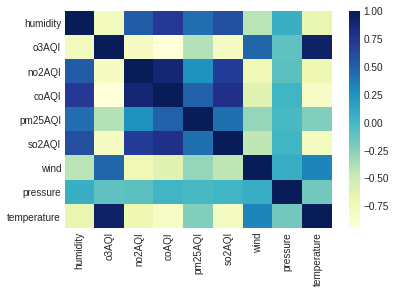

In [0]:
ds = df_daily_summary
corr = ds.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")

From the correlation matrix we clearly notice that temperature's correlation with Ozone (o3AQI) is significantly higher than all the other attributes. Therefore, we can primarily assume that this particle has much impact on changing the temperature.

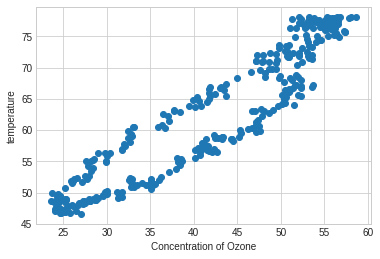

In [0]:
plt.scatter(ds['o3AQI'], ds['temperature'])
plt.xlabel('Concentration of Ozone')
plt.ylabel('temperature')
plt.show()

In [0]:
from sklearn import linear_model

ds = df_daily_summary
ds = ds.drop('o3AQI', axis=1)
y = ds['temperature']
ds.head()
X = ds
X = X.drop('temperature', axis=1)
X.head()
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print(lm.score(X,y))

0.863981740792025


Since we found a better correlation of Ozone (o3AQI) with temperature, we wanted to explore that further more. A linear regression model is built with the o3AQI to predict the temperature. The score looks promising to predict the temperature.

# Building Prediction Model

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
ds = df_daily_regr

# total number of observations
print('Number of observations (day in a year):', len(ds))

# labels to predict
labels=np.array(ds['temperature'])
ds=ds.drop('temperature', axis=1)

feature_list=list(ds.columns)
ds=np.array(ds)

# splitting the dataset into training and testing subset
train_features, test_features, train_labels, test_labels = train_test_split(ds, labels, test_size=0.30, random_state=15)

Number of observations (day in a year): 366


Splitting the data frame into train and test subset. For testing, we randomly selected 30% of the data from the entire year sample. 

In [0]:
# Applying random forest regressor to build the model and predict the labels
rf = RandomForestRegressor(n_estimators=1000, random_state=0)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

In [0]:
# Calculating mean absolute percentage error
mape = 100 * (errors / test_labels)
prediction_accuracy = round((100 - np.mean(mape)), 2)
print('Accuracy:', prediction_accuracy, '%.')

Accuracy: 97.74 %.


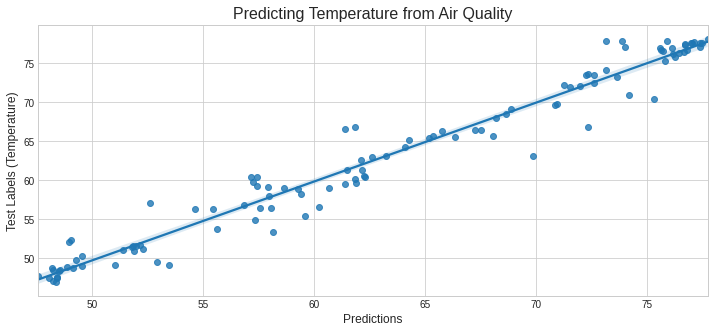

In [0]:
# Build a regression plot of predicted values and test_labels
df = pd.DataFrame({'predictions': predictions, 'test_labels': test_labels})
plt.subplots(figsize=(12,5))
sns.regplot(data=df, x='predictions', y='test_labels')
plt.ylabel('Test Labels (Temperature)', fontsize=12)
plt.xlabel('Predictions', fontsize=12)
# plt.xlim(1, 366)
plt.title('Predicting Temperature from Air Quality', fontsize=16)
plt.show()

From the prediction model we fit the testing data and shows a fairly good prediction result. The chart above shows the predicted vs the labeled data.

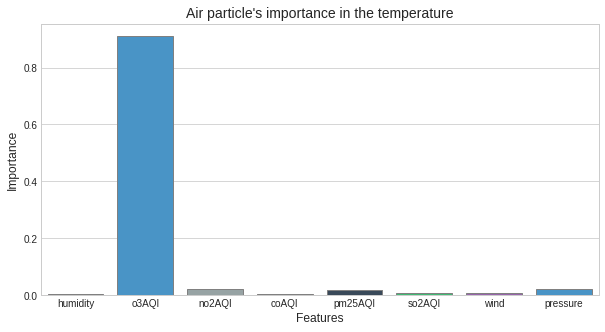

In [0]:
# Finding importance of the particles in the air that impacts the temperature
importances = list(rf.feature_importances_)

plt.subplots(figsize=(10,5))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.barplot(x=feature_list, y=importances, palette=sns.color_palette(flatui), edgecolor="gray")
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title('Air particle\'s importance in the temperature', fontsize=14)
plt.show()

We also wanted to identify which features are significant in impacting the tempearture. From chart above we can confirm that our initial assumption was true. Ozone (o3AQI) does have a significant impact in temperature. All the other particles or attributes posses similar importance, far less than Ozone.

### References

1.   https://console.cloud.google.com/marketplace/details/epa/historical-air-quality
2.   https://www.tensorflow.org/guide/keras/rnn
3.   https://www.kaggle.com/arjunshakdher/data-mining-ml-using-air-quality-data

